In [1]:
#欠損値の予測とスタッキング1層目の予測
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [3]:
train_tree = pd.read_csv("gdrive/My Drive/signate-bank/data/train_fixed.csv")
test_tree = pd.read_csv("gdrive/My Drive/signate-bank/data/test_fixed.csv")

In [4]:
train_linear = pd.read_csv("gdrive/My Drive/signate-bank/data/train_fixed_dummies.csv")
test_linear = pd.read_csv("gdrive/My Drive/signate-bank/data/test_fixed_dummies.csv")

In [5]:
train_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 27100 non-null  int64  
 1   job                27100 non-null  int64  
 2   marital            27100 non-null  int64  
 3   education          27100 non-null  int64  
 4   default            27100 non-null  int64  
 5   housing            27100 non-null  int64  
 6   loan               27100 non-null  int64  
 7   contact            27100 non-null  int64  
 8   month              27100 non-null  int64  
 9   campaign           27100 non-null  int64  
 10  previous           27100 non-null  int64  
 11  poutcome           27100 non-null  int64  
 12  y                  27100 non-null  float64
 13  edu_unknown_flg    27100 non-null  int64  
 14  balance_minus_flg  27100 non-null  int64  
 15  con_unknown_flg    27100 non-null  int64  
 16  duration_zero_flg  271

In [6]:
test_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 18050 non-null  int64  
 1   job                18050 non-null  int64  
 2   marital            18050 non-null  int64  
 3   education          18050 non-null  int64  
 4   default            18050 non-null  int64  
 5   housing            18050 non-null  int64  
 6   loan               18050 non-null  int64  
 7   contact            18050 non-null  int64  
 8   month              18050 non-null  int64  
 9   campaign           18050 non-null  int64  
 10  previous           18050 non-null  int64  
 11  poutcome           18050 non-null  int64  
 12  edu_unknown_flg    18050 non-null  int64  
 13  balance_minus_flg  18050 non-null  int64  
 14  con_unknown_flg    18050 non-null  int64  
 15  duration_zero_flg  18050 non-null  int64  
 16  pdays_flg          180

In [7]:
train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 27100 non-null  int64  
 1   default            27100 non-null  int64  
 2   housing            27100 non-null  int64  
 3   loan               27100 non-null  int64  
 4   poutcome           27100 non-null  int64  
 5   y                  27100 non-null  float64
 6   edu_unknown_flg    27100 non-null  int64  
 7   balance_minus_flg  27100 non-null  int64  
 8   con_unknown_flg    27100 non-null  int64  
 9   duration_zero_flg  27100 non-null  int64  
 10  pdays_flg          27100 non-null  int64  
 11  pou_unknown_flg    27100 non-null  int64  
 12  age                27100 non-null  float64
 13  balance            27100 non-null  float64
 14  day                27100 non-null  float64
 15  month+day          27100 non-null  float64
 16  duration_sc        270

In [8]:
test_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 18050 non-null  int64  
 1   default            18050 non-null  int64  
 2   housing            18050 non-null  int64  
 3   loan               18050 non-null  int64  
 4   poutcome           18050 non-null  int64  
 5   edu_unknown_flg    18050 non-null  int64  
 6   balance_minus_flg  18050 non-null  int64  
 7   con_unknown_flg    18050 non-null  int64  
 8   duration_zero_flg  18050 non-null  int64  
 9   pdays_flg          18050 non-null  int64  
 10  pou_unknown_flg    18050 non-null  int64  
 11  age                18050 non-null  float64
 12  balance            18050 non-null  float64
 13  day                18050 non-null  float64
 14  month+day          18050 non-null  float64
 15  duration_sc        18041 non-null  float64
 16  pdays_sc           180

In [9]:
tmp_y_train = train_tree["y"]
train_tree = train_tree.drop(["id","y"],axis=1)
test_tree = test_tree.drop(["id"],axis=1)
train_linear = train_linear.drop(["id","y"],axis=1)
test_linear = test_linear.drop(["id"],axis=1)

In [10]:
train_test_tree = pd.concat([train_tree,test_tree],axis=0).reset_index(drop=True)
train_test_linear = pd.concat([train_linear,test_linear],axis=0).reset_index(drop=True)

In [12]:
#educationの欠損値予測は精度が下がったため不採用
#edu_train = train_test[train_test["education"]!=3]
#edu_test,test_index = train_test[train_test["education"]==3],train_test[train_test["education"]==3].index.values

In [13]:
#x_train = edu_train.drop("education",axis=1)
#y_train = edu_train["education"]
    
#x_valid = edu_test.drop("education",axis=1)
    
#dtrain = xgb.DMatrix(x_train,label=y_train)
#dvalid = xgb.DMatrix(x_valid)

#params = {'objective':'multi:softmax',
#          'num_class':3,
#          'eval_metric':'mlogloss',
#          'silent':1,
#          'random_state':1,
#          'eta':0.3,
#          'max_depth':5
#         }

#num_round = 100
  
#model = xgb.train(params,dtrain,num_round)

#valid_pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    

In [14]:
#valid_pred = pd.Series(valid_pred,name="pred_edu",index=test_index)

In [15]:
#train_test.loc[test_index,'education'] = valid_pred.astype(int)

In [16]:
#train = train_test[:27100]
#test = train_test[27100:]

In [17]:
#train_test

In [18]:
#durationの予測
dur_train = train_test_linear[train_test_linear["duration_sc"].isnull()==False]
dur_test = train_test_linear[train_test_linear["duration_sc"].isnull()]
test_index = train_test_linear[train_test_linear["duration_sc"].isnull()].index.values

In [19]:
dur_train["duration_sc"].describe()

count    4.512700e+04
mean     2.035585e-17
std      1.000011e+00
min     -1.048260e+00
25%     -5.251911e-01
50%     -3.459915e-01
75%      5.596932e-01
max      1.378656e+01
Name: duration_sc, dtype: float64

In [20]:
dur_train["duration_sc"] = np.log(dur_train["duration_sc"] + 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
n_split = 5
valid_pred = np.zeros(len(dur_train))
kf_test_pred = np.zeros((len(dur_test),5))
kf = KFold(n_splits=5,shuffle=True,random_state=0)
i = 0

for train_idx,valid_idx in kf.split(dur_train):
    x_train = dur_train.drop("duration_sc",axis=1).iloc[train_idx]
    y_train = dur_train["duration_sc"].iloc[train_idx]
    
    x_valid = dur_train.drop("duration_sc",axis=1).iloc[valid_idx]
    y_valid = dur_train["duration_sc"].iloc[valid_idx]
    
    x_test = dur_test.drop(["duration_sc"],axis=1)
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)
    dtest = xgb.DMatrix(x_test)

    params = {'objective':'reg:squarederror',
             'eval_metric':'rmse',
             'silent':1,
             'random_state':1,
             'eta':0.4,
             'max_depth':3
              }
    
    watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round,evals=watch_list)

    valid_pred[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    kf_test_pred[:,i] = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    i = 1 + i

test_pred = kf_test_pred.mean(axis=1)
rmse = metrics.mean_squared_error(dur_train["duration_sc"],valid_pred)
print(rmse)

[0]	train-rmse:0.360255	eval-rmse:0.35373
[1]	train-rmse:0.347202	eval-rmse:0.34244
[2]	train-rmse:0.341441	eval-rmse:0.336977
[3]	train-rmse:0.338302	eval-rmse:0.334394
[4]	train-rmse:0.33564	eval-rmse:0.332077
[5]	train-rmse:0.334478	eval-rmse:0.331022
[6]	train-rmse:0.333678	eval-rmse:0.330461
[7]	train-rmse:0.332963	eval-rmse:0.329721
[8]	train-rmse:0.332074	eval-rmse:0.32904
[9]	train-rmse:0.331416	eval-rmse:0.328573
[10]	train-rmse:0.330894	eval-rmse:0.328145
[11]	train-rmse:0.330362	eval-rmse:0.327754
[12]	train-rmse:0.329917	eval-rmse:0.327309
[13]	train-rmse:0.329607	eval-rmse:0.327272
[14]	train-rmse:0.329435	eval-rmse:0.327242
[15]	train-rmse:0.32873	eval-rmse:0.326767
[16]	train-rmse:0.328487	eval-rmse:0.326581
[17]	train-rmse:0.32834	eval-rmse:0.3267
[18]	train-rmse:0.327955	eval-rmse:0.326484
[19]	train-rmse:0.327679	eval-rmse:0.326653
[20]	train-rmse:0.32753	eval-rmse:0.326828
[21]	train-rmse:0.327379	eval-rmse:0.326793
[22]	train-rmse:0.326913	eval-rmse:0.326431
[23]	tr

In [22]:
test_pred = pd.Series(test_pred,name="pred_dur",index=test_index)

In [23]:
train_test_linear.loc[test_index,'duration_sc'] = test_pred.astype(int)

In [24]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

In [25]:
#pdaysの予測
pda_train = train_test_linear[train_test_linear["pdays_sc"].isnull()==False]
pda_test = train_test_linear[train_test_linear["pdays_sc"].isnull()]
test_index = train_test_linear[train_test_linear["pdays_sc"].isnull()].index.values

In [26]:
pda_train["pdays_sc"].describe()

count    4.509800e+04
mean     1.196435e-17
std      1.000011e+00
min     -1.727057e+00
25%     -8.644407e-01
50%      2.151106e-03
75%      8.647677e-01
max      1.731359e+00
Name: pdays_sc, dtype: float64

In [27]:
pda_train["pdays_sc"] = np.log(pda_train["pdays_sc"] + 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
n_split = 5
valid_pred = np.zeros(len(pda_train))
kf_test_pred = np.zeros((len(pda_test),5))
kf = KFold(n_splits=5,shuffle=True,random_state=0)
i = 0

for train_idx,valid_idx in kf.split(pda_train):
    x_train = pda_train.drop("pdays_sc",axis=1).iloc[train_idx]
    y_train = pda_train["pdays_sc"].iloc[train_idx]
    
    x_valid = pda_train.drop("pdays_sc",axis=1).iloc[valid_idx]
    y_valid = pda_train["pdays_sc"].iloc[valid_idx]
    
    x_test = pda_test.drop(["pdays_sc"],axis=1)
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)
    dtest = xgb.DMatrix(x_test)

    params = {'objective':'reg:squarederror',
             'eval_metric':'rmse',
             'silent':1,
             'random_state':1,
             'eta':0.2,
             'max_depth':1
              }
    
    watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round,evals=watch_list)

    valid_pred[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    kf_test_pred[:,i] = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    i = 1 + i

test_pred = kf_test_pred.mean(axis=1)
rmse = metrics.mean_squared_error(pda_train["pdays_sc"],valid_pred)
print(rmse)

[0]	train-rmse:0.64887	eval-rmse:0.645545
[1]	train-rmse:0.648761	eval-rmse:0.645458
[2]	train-rmse:0.648691	eval-rmse:0.645379
[3]	train-rmse:0.648636	eval-rmse:0.645367
[4]	train-rmse:0.648592	eval-rmse:0.645336
[5]	train-rmse:0.648557	eval-rmse:0.645328
[6]	train-rmse:0.648532	eval-rmse:0.645352
[7]	train-rmse:0.648508	eval-rmse:0.645347
[8]	train-rmse:0.648488	eval-rmse:0.64532
[9]	train-rmse:0.648471	eval-rmse:0.645337
[10]	train-rmse:0.648454	eval-rmse:0.645345
[11]	train-rmse:0.648439	eval-rmse:0.645351
[12]	train-rmse:0.648428	eval-rmse:0.645332
[13]	train-rmse:0.648413	eval-rmse:0.645335
[14]	train-rmse:0.648403	eval-rmse:0.645331
[15]	train-rmse:0.648391	eval-rmse:0.645329
[16]	train-rmse:0.648379	eval-rmse:0.645328
[17]	train-rmse:0.648369	eval-rmse:0.645322
[18]	train-rmse:0.648358	eval-rmse:0.645323
[19]	train-rmse:0.648349	eval-rmse:0.645321
[20]	train-rmse:0.648339	eval-rmse:0.645338
[21]	train-rmse:0.648328	eval-rmse:0.645322
[22]	train-rmse:0.648318	eval-rmse:0.645321


In [29]:
test_pred = pd.Series(test_pred,name="pred_pda",index=test_index)

In [30]:
train_test_linear.loc[test_index,'pdays_sc'] = test_pred.astype(int)

In [31]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

In [32]:
#poutcomeの予測
pou_train = train_test_linear[train_test_linear["poutcome"]!=3]
pou_test = train_test_linear[train_test_linear["poutcome"]==3]
test_index = train_test_linear[train_test_linear["poutcome"]==3].index.values

In [33]:
n_split = 5
valid_pred = np.zeros(len(pou_train))
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
i = 0
for train_idx,valid_idx in skf.split(pou_train.drop(["poutcome"],axis=1),pou_train["poutcome"]):

    x_train = pou_train.drop("poutcome",axis=1).iloc[train_idx]
    y_train = pou_train["poutcome"].iloc[train_idx]
    
    x_valid = pou_train.drop("poutcome",axis=1).iloc[valid_idx]
    y_valid = pou_train["poutcome"].iloc[valid_idx]
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)

    params = {'objective':'multi:softmax',
              'num_class':3,
              'eval_metric':'mlogloss',
              'silent':1,
              'random_state':1,
              'eta':0.2,
              'max_depth':4
             }
    
    watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round,evals=watch_list)

    valid_pred[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)


[0]	train-mlogloss:0.997258	eval-mlogloss:0.999934
[1]	train-mlogloss:0.922943	eval-mlogloss:0.928804
[2]	train-mlogloss:0.867959	eval-mlogloss:0.87542
[3]	train-mlogloss:0.82551	eval-mlogloss:0.836091
[4]	train-mlogloss:0.792654	eval-mlogloss:0.806094
[5]	train-mlogloss:0.767034	eval-mlogloss:0.782563
[6]	train-mlogloss:0.746427	eval-mlogloss:0.763728
[7]	train-mlogloss:0.725506	eval-mlogloss:0.744363
[8]	train-mlogloss:0.711437	eval-mlogloss:0.733168
[9]	train-mlogloss:0.696625	eval-mlogloss:0.720784
[10]	train-mlogloss:0.684052	eval-mlogloss:0.710714
[11]	train-mlogloss:0.674041	eval-mlogloss:0.702916
[12]	train-mlogloss:0.663157	eval-mlogloss:0.694509
[13]	train-mlogloss:0.655382	eval-mlogloss:0.689178
[14]	train-mlogloss:0.648696	eval-mlogloss:0.684384
[15]	train-mlogloss:0.639109	eval-mlogloss:0.676582
[16]	train-mlogloss:0.633343	eval-mlogloss:0.673666
[17]	train-mlogloss:0.62868	eval-mlogloss:0.670883
[18]	train-mlogloss:0.623862	eval-mlogloss:0.66847
[19]	train-mlogloss:0.6190

In [34]:
x_train = pou_train.drop("poutcome",axis=1)
y_train = pou_train["poutcome"]
    
x_valid = pou_test.drop("poutcome",axis=1)
    
dtrain = xgb.DMatrix(x_train,label=y_train)
dvalid = xgb.DMatrix(x_valid)

params = {'objective':'multi:softmax',
          'num_class':3,
          'eval_metric':'mlogloss',
          'silent':1,
          'random_state':1,
          'eta':0.2,
          'max_depth':4
         }

num_round = 100
  
model = xgb.train(params,dtrain,num_round)

valid_pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    

In [35]:
valid_pred = pd.Series(valid_pred,name="pred_pou",index=test_index)

In [36]:
train_test_linear.loc[test_index,'poutcome'] = valid_pred.astype(int)

In [37]:
train_test_tree["duration_sc"] = train_test_linear["duration_sc"]
train_test_tree["pdays_sc"] = train_test_linear["pdays_sc"]
train_test_tree["poutcome"] = train_test_linear["poutcome"]

In [38]:
tmp = pd.get_dummies(train_test_tree["poutcome"],drop_first=True,prefix="poutcome")
train_test_linear = pd.concat([train_test_linear,tmp],axis=1)

In [39]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [40]:
train_tree["y"] = tmp_y_train
train_linear["y"] = tmp_y_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
train_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   job                27100 non-null  int64  
 1   marital            27100 non-null  int64  
 2   education          27100 non-null  int64  
 3   default            27100 non-null  int64  
 4   housing            27100 non-null  int64  
 5   loan               27100 non-null  int64  
 6   contact            27100 non-null  int64  
 7   month              27100 non-null  int64  
 8   campaign           27100 non-null  int64  
 9   previous           27100 non-null  int64  
 10  poutcome           27100 non-null  int64  
 11  edu_unknown_flg    27100 non-null  int64  
 12  balance_minus_flg  27100 non-null  int64  
 13  con_unknown_flg    27100 non-null  int64  
 14  duration_zero_flg  27100 non-null  int64  
 15  pdays_flg          27100 non-null  int64  
 16  pou_unknown_flg    271

In [42]:
train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            27100 non-null  int64  
 1   housing            27100 non-null  int64  
 2   loan               27100 non-null  int64  
 3   poutcome           27100 non-null  int64  
 4   edu_unknown_flg    27100 non-null  int64  
 5   balance_minus_flg  27100 non-null  int64  
 6   con_unknown_flg    27100 non-null  int64  
 7   duration_zero_flg  27100 non-null  int64  
 8   pdays_flg          27100 non-null  int64  
 9   pou_unknown_flg    27100 non-null  int64  
 10  age                27100 non-null  float64
 11  balance            27100 non-null  float64
 12  day                27100 non-null  float64
 13  month+day          27100 non-null  float64
 14  duration_sc        27100 non-null  float64
 15  pdays_sc           27100 non-null  float64
 16  job_1250           271

In [43]:
cat_columns = ["job","marital","contact","campaign","previous"
               ,"month","education","poutcome"
              ]

In [44]:
for c in cat_columns:
    test_tree[c] = test_tree[c].map(train_tree.groupby(c)["y"].mean())
    test_tree[c] = test_tree[c].fillna(train_tree.groupby(c)["y"].mean().mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
#カテゴリ変数をターゲットエンコーディング
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
for c in cat_columns:
    tmp = np.repeat(np.nan,train_tree.shape[0])
    for train_idx,valid_idx in skf.split(train_tree,train_tree["y"]):
        target_mean = train_tree.iloc[train_idx].groupby(c)["y"].mean()
        tmp[valid_idx] = train_tree[c].iloc[valid_idx].map(target_mean)
        train_tree[c].iloc[valid_idx] = train_tree[c].iloc[valid_idx].fillna(target_mean.mean())
    train_tree[c] = tmp

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [46]:
train_linear[cat_columns] = train_tree[cat_columns]
test_linear[cat_columns] = test_tree[cat_columns]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [47]:
print(train_linear.isnull().sum().sum())
print(test_linear.isnull().sum().sum())
print(train_tree.isnull().sum().sum())
print(test_tree.isnull().sum().sum())

0
0
0
0


## stacking 1-1

In [48]:
#stacking 1-1
n_split = 5
valid_pred_1 = np.zeros(len(train_tree))
test_pred_1 = np.zeros((len(test_tree),n_split))
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
i = 0
for train_idx,valid_idx in skf.split(train_tree,train_tree["y"]):

    x_train = train_tree.drop("y",axis=1).iloc[train_idx]
    y_train = train_tree["y"].iloc[train_idx]
    
    x_valid = train_tree.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_tree["y"].iloc[valid_idx]
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)
    dtest = xgb.DMatrix(test_tree)

    params = {'objective':'binary:logistic',
             'eval_metric':'auc',
             'random_state':1,
             'eta':0.35,
             'max_depth':3
             }
    
    #watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round
                     # ,evals=watch_list
                     )

    valid_pred_1[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    test_pred_1[:,i] = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    
    i = i + 1


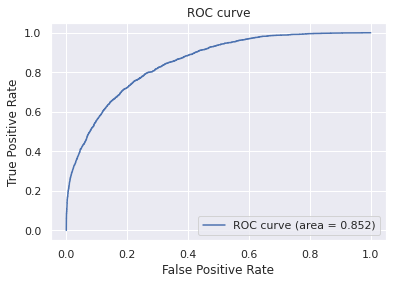

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(tmp_y_train, valid_pred_1)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [50]:
valid_pred_1 = pd.Series(valid_pred_1,name="prob_1")
test_pred_1 = pd.Series(test_pred_1.mean(axis=1),name="prob_1")

## stacking 1-2

In [51]:
#stacking 1-2
n_split = 5
valid_pred_2 = np.zeros(len(train_tree))
test_pred_2 = np.zeros((len(test_tree),n_split))
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=1)
i = 0
for train_idx,valid_idx in skf.split(train_tree,train_tree["y"]):

    x_train = train_tree.drop("y",axis=1).iloc[train_idx]
    y_train = train_tree["y"].iloc[train_idx]
    
    x_valid = train_tree.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_tree["y"].iloc[valid_idx]
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)
    dtest = xgb.DMatrix(test_tree)

    params = {'objective':'binary:logistic',
             'eval_metric':'auc',
             'random_state':1,
             'eta':0.4,
             'max_depth':3
             }
    
    #watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round
                     # ,evals=watch_list
                     )

    valid_pred_2[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    test_pred_2[:,i] = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    
    i = i + 1


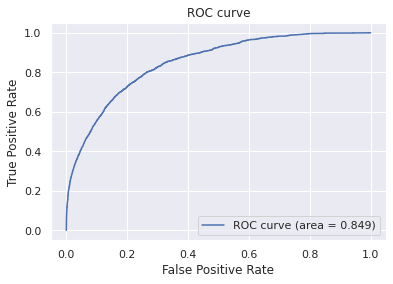

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(train_tree["y"], valid_pred_2)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [53]:
valid_pred_2 = pd.Series(valid_pred_2,name="prob_2")
test_pred_2 = pd.Series(test_pred_2.mean(axis=1),name="prob_2")

## stacking 1-3

In [54]:
#stacking 1-3
n_split = 5
valid_pred_3 = np.zeros(len(train_tree))
test_pred_3 = np.zeros((len(test_tree),n_split))
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
i = 0
for train_idx,valid_idx in skf.split(train_tree,train_tree["y"]):

    x_train = train_tree.drop("y",axis=1).iloc[train_idx]
    y_train = train_tree["y"].iloc[train_idx]
    
    x_valid = train_tree.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_tree["y"].iloc[valid_idx]
    
    dtrain = xgb.DMatrix(x_train,label=y_train)
    dvalid = xgb.DMatrix(x_valid,label=y_valid)
    dtest = xgb.DMatrix(test_tree)

    params = {'objective':'binary:logistic',
             'eval_metric':'auc',
             'random_state':1,
             'eta':0.2,
             'max_depth':4
             }
    
    #watch_list = [(dtrain,'train'),(dvalid,'eval')]
    num_round = 100
  
    model = xgb.train(params,dtrain,num_round
                     # ,evals=watch_list
                     )

    valid_pred_3[valid_idx] = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    test_pred_3[:,i] = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    
    i = i + 1


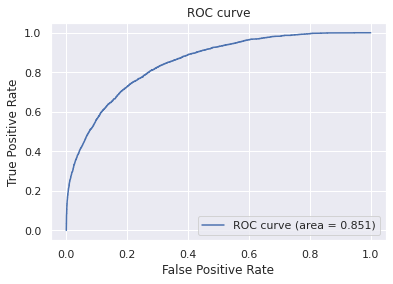

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(train_tree["y"], valid_pred_3)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [56]:
valid_pred_3 = pd.Series(valid_pred_3,name="prob_3")
test_pred_3 = pd.Series(test_pred_3.mean(axis=1),name="prob_3")

In [57]:
train_linear.columns.values

array(['default', 'housing', 'loan', 'poutcome', 'edu_unknown_flg',
       'balance_minus_flg', 'con_unknown_flg', 'duration_zero_flg',
       'pdays_flg', 'pou_unknown_flg', 'age', 'balance', 'day',
       'month+day', 'duration_sc', 'pdays_sc', 'job_1250', 'job_1306',
       'job_1661', 'job_1884', 'job_1890', 'job_4192', 'job_5339',
       'job_583', 'job_8128', 'job_8873', 'marital_1', 'marital_2',
       'contact_1', 'contact_2', 'campaign_2', 'campaign_3', 'campaign_4',
       'previous_1', 'previous_2', 'previous_3', 'month_10', 'month_11',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'education_1771', 'education_26754',
       'education_5560', 'poutcome_1', 'poutcome_2', 'y', 'job',
       'marital', 'contact', 'campaign', 'previous', 'month', 'education'],
      dtype=object)

In [58]:
columns =['default',
          'housing', 
          'loan', 
          'poutcome', 
          'balance_minus_flg',
          'duration_zero_flg', 
          'pdays_flg', 
          'age', 
          'balance', 
          'day',
          'month+day', 
          'duration_sc', 
          'pdays_sc', 
          'job_1250', 'job_1306','job_1661', 'job_1884', 'job_1890', 'job_4192', 'job_5339','job_583', 'job_8128', 'job_8873', 
          'marital_1', 'marital_2',
          'contact_1', 'contact_2', 
          'campaign_2', 'campaign_3', 'campaign_4',
          'previous_1', 'previous_2', 'previous_3', 
          'month_10', 'month_11','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 
          'education_1771', 'education_26754','education_5560', 
          'poutcome_1', 'poutcome_2', 
          #'job',
          #'marital',
          #'contact',
          #'campaign',
          #'previous',
          #'month',
          #'education'
         ]

In [59]:
train_lr = pd.concat([train_linear[columns],train_linear["y"]],axis=1)
test_lr = test_linear[columns]

## stacking 1-4

In [60]:
#stacking grid search

#max_score = 0

#LR_grid = {LogisticRegression(): {"C": [0.1],
#                                  "random_state": [1],
#                                  "penalty":["elasticnet"],
#                                  "class_weight":["balanced","None"],
#                                  "max_iter":[800],
#                                  "solver":["saga"],
#                                  "l1_ratio":[0.2,0.4,0.6,0.8]}}

#x_train,x_test,y_train,y_test = train_test_split(train_linear,tmp_y_train)

#for model, param in LR_grid.items():
#    clf = GridSearchCV(model, param)
#    clf.fit(x_train, y_train)
#    y_pred = clf.predict(x_test)
#    fpr, tpr, thresholds = metrics.roc_curve(tmp_y_train, valid_pred_4)
#    auc = metrics.auc(fpr, tpr)
#    score = auc

#    if max_score < score:
#        max_score = score
#        best_param = clf.best_params_
#        best_model = model.__class__.__name__



#print("ベストスコア:{}".format(max_score))
#print("モデル:{}".format(best_model))
#print("パラメーター:{}".format(best_param))

In [61]:
#stacking 1-4
n_split = 5
valid_pred_4 = np.zeros(len(train_lr))
test_pred_4 = np.zeros((len(test_lr),n_split))
skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
i = 0
for train_idx,valid_idx in skf.split(train_lr,train_lr["y"]):

    x_train = train_lr.drop("y",axis=1).iloc[train_idx]
    y_train = train_lr["y"].iloc[train_idx]
    
    x_valid = train_lr.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_lr["y"].iloc[valid_idx]
    
    lr = LogisticRegression(random_state=1,solver="saga",penalty="elasticnet",max_iter=800,l1_ratio=0.6,class_weight="None",C=0.1)
    
    lr.fit(x_train,y_train)
    
    valid_pred_4[valid_idx] = lr.predict_proba(x_valid)[:,1]
    test_pred_4[:,i] = lr.predict_proba(test_lr)[:,1]
    
    i = i + 1

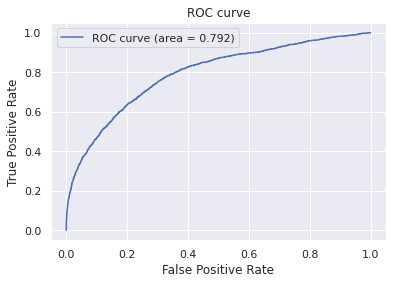

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(train_lr["y"], valid_pred_4)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [63]:
valid_pred_4 = pd.Series(valid_pred_4,name="prob_4")
test_pred_4 = pd.Series(test_pred_4.mean(axis=1),name="prob_4")

## stacking 1-5

In [64]:
columns =[#'default',
          'housing', 
          'loan', 
          'poutcome', 
          #'balance_minus_flg',
          #'duration_zero_flg', 
          #'pdays_flg', 
          'age', 
          'balance', 
          'day',
          'month+day', 
          'duration_sc', 
          'pdays_sc', 
          #'job_1250', 'job_1306','job_1661', 'job_1884', 'job_1890', 'job_4192', 'job_5339','job_583', 'job_8128', 'job_8873', 
          'marital_1', 'marital_2',
          'contact_1', 'contact_2', 
          #'campaign_2', 'campaign_3', 'campaign_4',
          'previous_1', 'previous_2', 'previous_3', 
          'month_10', 'month_11','month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 
          'education_1771', 'education_26754','education_5560', 
          'poutcome_1', 'poutcome_2', 
          'job',
          #'marital',
          #'contact',
          #'campaign',
          'previous',
          'month',
          #'education'
         ]

In [65]:
train_knn = pd.concat([train_linear[columns],train_linear["y"]],axis=1)
test_knn = test_linear[columns]

In [66]:
train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            27100 non-null  int64  
 1   housing            27100 non-null  int64  
 2   loan               27100 non-null  int64  
 3   poutcome           27100 non-null  float64
 4   edu_unknown_flg    27100 non-null  int64  
 5   balance_minus_flg  27100 non-null  int64  
 6   con_unknown_flg    27100 non-null  int64  
 7   duration_zero_flg  27100 non-null  int64  
 8   pdays_flg          27100 non-null  int64  
 9   pou_unknown_flg    27100 non-null  int64  
 10  age                27100 non-null  float64
 11  balance            27100 non-null  float64
 12  day                27100 non-null  float64
 13  month+day          27100 non-null  float64
 14  duration_sc        27100 non-null  float64
 15  pdays_sc           27100 non-null  float64
 16  job_1250           271

In [67]:
#stacking 1-5
#n_split = 5

#skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
#test_pred_5 = np.zeros((len(test_linear),n_split))

#auc_list = []
#for n in range(80,130,10):
#    valid_pred_5 = np.zeros(len(train_linear))
#    i = 0
#    for train_idx,valid_idx in skf.split(train_linear,train_linear["y"]):

#        x_train = train_linear.drop("y",axis=1).iloc[train_idx]
#        y_train = train_linear["y"].iloc[train_idx]

#        x_valid = train_linear.drop("y",axis=1).iloc[valid_idx]
#        y_valid = train_linear["y"].iloc[valid_idx]

#        knn = KNeighborsClassifier(n_neighbors=n,weights="distance")

#        knn.fit(x_train,y_train)

#        valid_pred_5[valid_idx] = knn.predict_proba(x_valid)[:,1]
        #test_pred_5[:,i] = knn.predict_proba(test_linear)[:,1]

#    fpr, tpr, thresholds = metrics.roc_curve(train_linear["y"], valid_pred_5)
#    auc = metrics.auc(fpr, tpr)
#    auc_list.append(auc)

In [68]:
#plt.plot(range(80,130,10),auc_list)

In [69]:
#stacking 1-5
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
test_pred_5 = np.zeros((len(test_knn),n_split))
valid_pred_5 = np.zeros(len(train_knn))

i = 0
for train_idx,valid_idx in skf.split(train_knn,train_knn["y"]):

    x_train = train_knn.drop("y",axis=1).iloc[train_idx]
    y_train = train_knn["y"].iloc[train_idx]

    x_valid = train_knn.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_knn["y"].iloc[valid_idx]

    knn = KNeighborsClassifier(n_neighbors=100)

    knn.fit(x_train,y_train)

    valid_pred_5[valid_idx] = knn.predict_proba(x_valid)[:,1]
    test_pred_5[:,i] = knn.predict_proba(test_knn)[:,1]

    i = i + 1

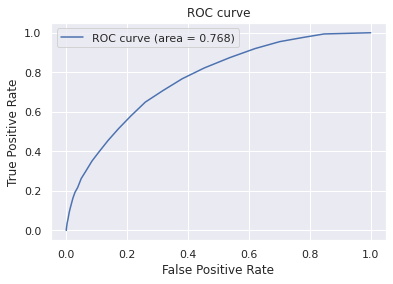

In [70]:
fpr, tpr, thresholds = metrics.roc_curve(train_knn["y"], valid_pred_5)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [71]:
valid_pred_5 = pd.Series(valid_pred_5,name="prob_5")
test_pred_5 = pd.Series(test_pred_5.mean(axis=1),name="prob_5")

## stacking 1-9

In [72]:
#stacking 1-9
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
test_pred_9 = np.zeros((len(test_knn),n_split))
valid_pred_9 = np.zeros(len(train_knn))

i = 0
for train_idx,valid_idx in skf.split(train_knn,train_knn["y"]):

    x_train = train_knn.drop("y",axis=1).iloc[train_idx]
    y_train = train_knn["y"].iloc[train_idx]

    x_valid = train_knn.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_knn["y"].iloc[valid_idx]

    knn = KNeighborsClassifier(n_neighbors=170)

    knn.fit(x_train,y_train)

    valid_pred_9[valid_idx] = knn.predict_proba(x_valid)[:,1]
    test_pred_9[:,i] = knn.predict_proba(test_knn)[:,1]

    i = i + 1

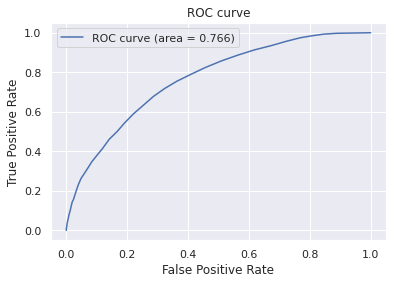

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(train_knn["y"], valid_pred_9)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [74]:
valid_pred_9 = pd.Series(valid_pred_9,name="prob_9")
test_pred_9 = pd.Series(test_pred_9.mean(axis=1),name="prob_9")

## stacking 1-6

In [75]:
from keras.layers import Dense,Dropout,advanced_activations,BatchNormalization
from keras.models import Sequential


In [76]:
def eval_auc(y_true,y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

In [77]:
train_linear

,default,housing,loan,poutcome,edu_unknown_flg,balance_minus_flg,con_unknown_flg,duration_zero_flg,pdays_flg,pou_unknown_flg,age,balance,day,month+day,duration_sc,pdays_sc,job_1250,job_1306,job_1661,job_1884,job_1890,job_4192,job_5339,job_583,job_8128,job_8873,marital_1,marital_2,contact_1,contact_2,campaign_2,campaign_3,campaign_4,previous_1,previous_2,previous_3,month_10,month_11,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,education_1771,education_26754,education_5560,poutcome_1,poutcome_2,y,job,marital,contact,campaign,previous,month,education
0,0,1,0,0.081363,0,0,0,0,1,0,-0.693855,-1.114015,0.495436,2.118140,-0.622056,0.252588,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,0.065749,0.062381,0.091638,0.086632,0.067672,0.065521,0.064364
1,0,0,0,0.063353,0,0,0,0,1,1,-1.043986,-0.140798,0.612122,1.145652,-0.345991,1.063527,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1.0,0.066741,0.121793,0.091082,0.064220,0.068077,0.069588,0.103647
2,0,1,0,0.064430,0,0,0,0,1,0,-0.056708,-1.115345,-0.671424,2.085616,0.588753,1.556451,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.086336,0.062567,0.090915,0.085290,0.067429,0.065027,0.104167
3,0,1,1,0.064262,0,0,1,0,1,0,-0.693855,1.635521,-0.087994,0.150396,2.075625,-1.250034,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.0,0.044586,0.062988,0.037923,0.068465,0.067236,0.044499,0.063723
4,0,1,0,0.063353,0,0,0,0,1,1,1.601526,-0.173162,-1.604911,-1.388022,-0.253970,-0.641830,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0.0,0.132686,0.061480,0.089485,0.087813,0.068077,0.201393,0.065258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0,1,0,0.064262,0,0,0,0,1,1,0.235035,-0.659058,1.195552,0.186173,0.559693,-0.037601,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.0,0.057119,0.062988,0.091542,0.051120,0.067236,0.044499,0.063723
27096,0,1,0,0.064430,0,0,0,0,1,1,-0.056708,-0.168570,1.195552,0.186173,-0.525191,1.131106,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.0,0.066969,0.062567,0.090915,0.085290,0.067429,0.044467,0.064599
27097,0,0,0,0.083174,1,0,0,0,1,1,-0.056708,-0.409840,1.312238,0.514673,-0.253970,-1.246059,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0.0,0.068389,0.061480,0.091082,0.064220,0.068077,0.057420,0.156725
27098,0,1,0,0.064262,0,0,0,0,1,1,-0.866002,1.651355,1.195552,0.186173,-0.525191,-1.329538,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.0,0.088872,0.119583,0.091542,0.087040,0.067236,0.044499,0.063723


In [78]:
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
test_pred_6 = np.zeros((len(test_linear),n_split))
valid_pred_6 = np.zeros((len(train_linear)))

i = 0

for train_idx,valid_idx in skf.split(train_linear,train_linear["y"]):

    x_train = train_linear.drop("y",axis=1).iloc[train_idx]
    y_train = train_linear["y"].iloc[train_idx]

    x_valid = train_linear.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_linear["y"].iloc[valid_idx]
    
    model = Sequential()
    model.add(Dense(32,activation=advanced_activations.LeakyReLU(alpha=0.1),input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16,activation=advanced_activations.LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32,activation=advanced_activations.LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=[keras.metrics.AUC()])

    batch_size = 150
    epoch = 20

    history=model.fit(x_train,y_train,
                     batch_size=batch_size,epochs=epoch,
                     verbose=1,validation_data=(x_valid,y_valid))


    valid_pred_6[valid_idx] = model.predict(x_valid).reshape(-1)
    test_pred_6[:,i] = model.predict(test_linear).reshape(-1)
    
    i = i + 1

Epoch 1/20
145/145 [==============================] - 1s 6ms/step - loss: 0.6511 - auc: 0.5354 - val_loss: 0.3803 - val_auc: 0.6354
Epoch 2/20
145/145 [==============================] - 1s 4ms/step - loss: 0.3842 - auc: 0.5681 - val_loss: 0.2733 - val_auc: 0.6718
Epoch 3/20
145/145 [==============================] - 1s 4ms/step - loss: 0.3016 - auc: 0.6062 - val_loss: 0.2405 - val_auc: 0.7473
Epoch 4/20
145/145 [==============================] - 1s 3ms/step - loss: 0.2778 - auc: 0.6577 - val_loss: 0.2353 - val_auc: 0.7751
Epoch 5/20
145/145 [==============================] - 0s 3ms/step - loss: 0.2629 - auc: 0.6914 - val_loss: 0.2278 - val_auc: 0.7907
Epoch 6/20
145/145 [==============================] - 1s 4ms/step - loss: 0.2545 - auc: 0.7072 - val_loss: 0.2237 - val_auc: 0.8014
Epoch 7/20
145/145 [==============================] - 1s 3ms/step - loss: 0.2508 - auc: 0.7207 - val_loss: 0.2211 - val_auc: 0.8092
Epoch 8/20
145/145 [==============================] - 1s 3ms/step - loss: 0.

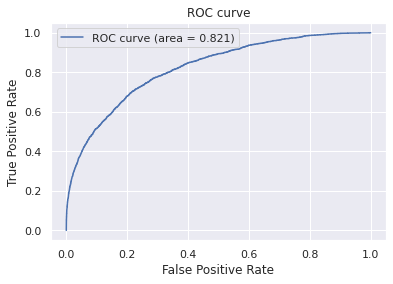

In [79]:
fpr, tpr, thresholds = metrics.roc_curve(train_linear["y"], valid_pred_6)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [80]:
valid_pred_6 = pd.Series(valid_pred_6,name="prob_6")
test_pred_6 = pd.Series(test_pred_6.mean(axis=1),name="prob_6")

In [81]:
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
test_pred_7 = np.zeros((len(test_linear),n_split))
valid_pred_7 = np.zeros((len(train_linear)))

i = 0

for train_idx,valid_idx in skf.split(train_linear,train_linear["y"]):

    x_train = train_linear.drop("y",axis=1).iloc[train_idx]
    y_train = train_linear["y"].iloc[train_idx]

    x_valid = train_linear.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_linear["y"].iloc[valid_idx]
    
    model = Sequential()
    model.add(Dense(32,activation="relu",input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=[keras.metrics.AUC()])

    batch_size = 128
    epoch = 20

    history=model.fit(x_train,y_train,
                     batch_size=batch_size,epochs=epoch,
                     verbose=1,validation_data=(x_valid,y_valid))


    valid_pred_7[valid_idx] = model.predict(x_valid).reshape(-1)
    test_pred_7[:,i] = model.predict(test_linear).reshape(-1)
    
    i = i + 1

Epoch 1/20
170/170 [==============================] - 1s 5ms/step - loss: 0.6129 - auc_5: 0.5503 - val_loss: 0.3773 - val_auc_5: 0.5992
Epoch 2/20
170/170 [==============================] - 1s 3ms/step - loss: 0.3547 - auc_5: 0.5694 - val_loss: 0.2652 - val_auc_5: 0.6767
Epoch 3/20
170/170 [==============================] - 1s 3ms/step - loss: 0.2882 - auc_5: 0.6222 - val_loss: 0.2433 - val_auc_5: 0.7326
Epoch 4/20
170/170 [==============================] - 1s 3ms/step - loss: 0.2711 - auc_5: 0.6680 - val_loss: 0.2325 - val_auc_5: 0.7706
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.2616 - auc_5: 0.6930 - val_loss: 0.2258 - val_auc_5: 0.7907
Epoch 6/20
170/170 [==============================] - 1s 3ms/step - loss: 0.2511 - auc_5: 0.7179 - val_loss: 0.2197 - val_auc_5: 0.8075
Epoch 7/20
170/170 [==============================] - 1s 3ms/step - loss: 0.2450 - auc_5: 0.7393 - val_loss: 0.2172 - val_auc_5: 0.8142
Epoch 8/20
170/170 [============================

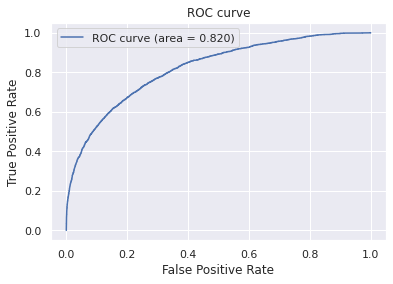

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(train_linear["y"], valid_pred_7)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [83]:
valid_pred_7 = pd.Series(valid_pred_7,name="prob_7")
test_pred_7 = pd.Series(test_pred_7.mean(axis=1),name="prob_7")

In [84]:
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2)
test_pred_8 = np.zeros((len(test_linear),n_split))
valid_pred_8 = np.zeros((len(train_linear)))

i = 0

for train_idx,valid_idx in skf.split(train_linear,train_linear["y"]):

    x_train = train_linear.drop("y",axis=1).iloc[train_idx]
    y_train = train_linear["y"].iloc[train_idx]

    x_valid = train_linear.drop("y",axis=1).iloc[valid_idx]
    y_valid = train_linear["y"].iloc[valid_idx]
    
    model = Sequential()
    model.add(Dense(32,activation="relu",input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=[keras.metrics.AUC()])

    batch_size = 128
    epoch = 20

    history=model.fit(x_train,y_train,
                     batch_size=batch_size,epochs=epoch,
                     verbose=1,validation_data=(x_valid,y_valid))


    valid_pred_8[valid_idx] = model.predict(x_valid).reshape(-1)
    test_pred_8[:,i] = model.predict(test_linear).reshape(-1)
    
    i = i + 1

Epoch 1/20
170/170 [==============================] - 1s 5ms/step - loss: 0.6239 - auc_10: 0.5592 - val_loss: 0.4377 - val_auc_10: 0.7190
Epoch 2/20
170/170 [==============================] - 0s 3ms/step - loss: 0.3736 - auc_10: 0.6289 - val_loss: 0.2716 - val_auc_10: 0.7618
Epoch 3/20
170/170 [==============================] - 0s 3ms/step - loss: 0.2729 - auc_10: 0.6985 - val_loss: 0.2288 - val_auc_10: 0.7948
Epoch 4/20
170/170 [==============================] - 0s 3ms/step - loss: 0.2499 - auc_10: 0.7325 - val_loss: 0.2187 - val_auc_10: 0.8148
Epoch 5/20
170/170 [==============================] - 0s 3ms/step - loss: 0.2395 - auc_10: 0.7534 - val_loss: 0.2126 - val_auc_10: 0.8220
Epoch 6/20
170/170 [==============================] - 0s 3ms/step - loss: 0.2360 - auc_10: 0.7642 - val_loss: 0.2111 - val_auc_10: 0.8284
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.2291 - auc_10: 0.7833 - val_loss: 0.2115 - val_auc_10: 0.8269
Epoch 8/20
170/170 [==============

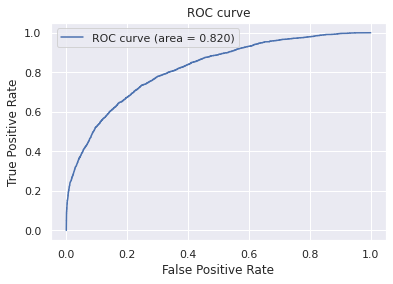

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(train_linear["y"], valid_pred_8)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [86]:
valid_pred_8 = pd.Series(valid_pred_8,name="prob_8")
test_pred_8 = pd.Series(test_pred_8.mean(axis=1),name="prob_8")

In [87]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [88]:
train_linear = pd.concat([train_linear,valid_pred_1,valid_pred_2,valid_pred_3,valid_pred_4,valid_pred_5,valid_pred_6,valid_pred_7,valid_pred_8,valid_pred_9],axis=1)
test_linear = pd.concat([test_linear.reset_index(drop=True),test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9],axis=1)

train_tree = pd.concat([train_tree,valid_pred_1,valid_pred_2,valid_pred_3,valid_pred_4,valid_pred_5,valid_pred_6,valid_pred_7,valid_pred_8,valid_pred_9],axis=1)
test_tree = pd.concat([test_tree.reset_index(drop=True),test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9],axis=1)

In [89]:
train_linear = pd.concat([train_linear,pd.Series(tmp_y_train,name="y")],axis=1)
train_tree = pd.concat([train_tree,pd.Series(tmp_y_train,name="y")],axis=1)

In [90]:
train_tree

,job,marital,education,default,housing,loan,contact,month,campaign,previous,poutcome,edu_unknown_flg,balance_minus_flg,con_unknown_flg,duration_zero_flg,pdays_flg,pou_unknown_flg,age,balance,day,month+day,duration_sc,pdays_sc,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,y
0,4192,2,26754,0,1,0,1,11,2,0,2,0,0,0,0,1,0,-0.693855,-1.114015,0.495436,2.118140,-0.622056,0.252588,0.013328,0.012472,0.009358,0.039733,0.02,0.010931,0.008151,0.005528,0.035294,0.0
1,1884,0,11065,0,0,0,1,8,3,0,1,0,0,0,0,1,1,-1.043986,-0.140798,0.612122,1.145652,-0.345991,1.063527,0.225955,0.124788,0.163078,0.089056,0.11,0.110140,0.108308,0.148197,0.100000,1.0
2,8873,2,11065,0,1,0,1,11,4,0,1,0,0,0,0,1,0,-0.056708,-1.115345,-0.671424,2.085616,0.588753,1.556451,0.004382,0.002172,0.007099,0.034349,0.04,0.003116,0.005899,0.001554,0.052941,0.0
3,8128,2,26754,0,1,1,0,5,3,0,1,0,0,1,0,1,0,-0.693855,1.635521,-0.087994,0.150396,2.075625,-1.250034,0.006659,0.006015,0.035795,0.005501,0.04,0.003706,0.007108,0.001686,0.029412,0.0
4,1306,2,5560,0,1,0,2,4,4,0,1,0,0,0,0,1,1,1.601526,-0.173162,-1.604911,-1.388022,-0.253970,-0.641830,0.036322,0.154770,0.096899,0.067868,0.14,0.120133,0.132712,0.060722,0.129412,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,10044,2,26754,0,1,0,1,5,1,0,1,0,0,0,0,1,1,0.235035,-0.659058,1.195552,0.186173,0.559693,-0.037601,0.004737,0.007879,0.005166,0.028354,0.00,0.010837,0.012773,0.010288,0.000000,0.0
27096,4192,2,26754,0,1,0,1,5,4,0,1,0,0,0,0,1,1,-0.056708,-0.168570,1.195552,0.186173,-0.525191,1.131106,0.024647,0.020254,0.014477,0.036536,0.00,0.007030,0.009482,0.014973,0.000000,0.0
27097,4192,2,1771,0,0,0,1,6,3,0,2,1,0,0,0,1,1,-0.056708,-0.409840,1.312238,0.514673,-0.253970,-1.246059,0.071415,0.070294,0.085141,0.114836,0.11,0.087959,0.166654,0.057493,0.117647,0.0
27098,5339,0,26754,0,1,0,1,5,4,0,1,0,0,0,0,1,1,-0.866002,1.651355,1.195552,0.186173,-0.525191,-1.329538,0.019143,0.029312,0.057831,0.049724,0.06,0.071011,0.093694,0.074528,0.052941,0.0


In [91]:
train_linear.to_csv("gdrive/My Drive/signate-bank/data/train_linear2.csv",index=False)
test_linear.to_csv("gdrive/My Drive/signate-bank/data/test_linear2.csv",index=False)

train_tree.to_csv("gdrive/My Drive/signate-bank/data/train_tree2.csv",index=False)
test_tree.to_csv("gdrive/My Drive/signate-bank/data/test_tree2.csv",index=False)

In [92]:
train_linear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            27100 non-null  int64  
 1   housing            27100 non-null  int64  
 2   loan               27100 non-null  int64  
 3   poutcome           27100 non-null  int64  
 4   edu_unknown_flg    27100 non-null  int64  
 5   balance_minus_flg  27100 non-null  int64  
 6   con_unknown_flg    27100 non-null  int64  
 7   duration_zero_flg  27100 non-null  int64  
 8   pdays_flg          27100 non-null  int64  
 9   pou_unknown_flg    27100 non-null  int64  
 10  age                27100 non-null  float64
 11  balance            27100 non-null  float64
 12  day                27100 non-null  float64
 13  month+day          27100 non-null  float64
 14  duration_sc        27100 non-null  float64
 15  pdays_sc           27100 non-null  float64
 16  job_1250           271